https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

In [1]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, MiniBatchNMF, LatentDirichletAllocation

from utils import ls, cat


In [2]:
DATA_DIR = '../../data'

ls(DATA_DIR)

DIR      ../../data/stopwords-ru
  4.1 MB ../../data/consultant-news-01.01.2022-08.10.2022.csv
  2.7 MB ../../data/consultant-news_lemmas.csv
  2.1 GB ../../data/lenta-ru-news.csv
 20.0  B ../../data/roles.csv
  6.7 MB ../../data/tg-channels.csv
 13.9 MB ../../data/train_lemmas.csv
 22.7 MB ../../data/train_tokens.csv


In [3]:
df = pd.read_csv(f'{DATA_DIR}/consultant-news_lemmas.csv', index_col=0)
df

,title,text
0,утвердить форма представлять сведение ликвидац...,утвердить форма работодатель передавать служба...
1,февраль допускать ребёнок заведение общепит ма...,февраль город запретить допускать несовершенно...
2,применение норма хранение документ приказ опуб...,применение стандарт перенести январь год обязы...
3,оператор связь банк планировать ввести новый ш...,чтение депутат согласиться установить админист...
4,согласный выдать иностранец чек tax free интер...,выдать чек tax free сформировать касса адрес у...
...,...,...
1858,новость специалист кадр сентябрь,материал частичный мобилизация новый антикризи...
1859,интересный новость специалист закупка сентябрь,материал частичный мобилизация новый антикризи...
1860,новость специалист организация здравоохранение...,лечение ребёнок сообщить определять законный п...
1861,новый антикризисный мера сентябрь,материал частичный мобилизация новый антикризи...


In [4]:
n_samples = len(df)

data_samples = df.head(n_samples)['text'].fillna('')
data_samples

0       утвердить форма работодатель передавать служба...
1       февраль город запретить допускать несовершенно...
2       применение стандарт перенести январь год обязы...
3       чтение депутат согласиться установить админист...
4       выдать чек tax free сформировать касса адрес у...
                              ...                        
1858    материал частичный мобилизация новый антикризи...
1859    материал частичный мобилизация новый антикризи...
1860    лечение ребёнок сообщить определять законный п...
1861    материал частичный мобилизация новый антикризи...
1862    счёт фактура октябрь выставлять получать едины...
Name: text, Length: 1863, dtype: object

In [25]:
n_features = 100
n_components = 50
n_top_words = 20
batch_size = 128
init = "nndsvda"
max_df=0.95
min_df=2

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[:10]):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


In [26]:
stop_words = ['год',
              'месяц',
              'день',
              'понедельник',
              'вторник',
              'среда',
              'четверг',
              'пятница',
              'суббота',
              'воскресенье',
              'январь',
              'февраль',
              'март',
              'апрель',
              'май',
              'июнь',
              'июль',
              'август',
              'сентябрь',
              'октябрь',
              'ноябрь',
              'декабрь',
              'вчера',
              'позавчера',
              'сегодня',
              'завтра',
              'послезавтра',
             ]

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=max_df, min_df=min_df, max_features=n_features, stop_words=stop_words
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=max_df, min_df=min_df, max_features=n_features, stop_words=stop_words
)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()


Extracting tf-idf features for NMF...
done in 0.139s.
Extracting tf features for LDA...
done in 0.083s.



Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=1863 and n_features=100...
done in 0.695s.


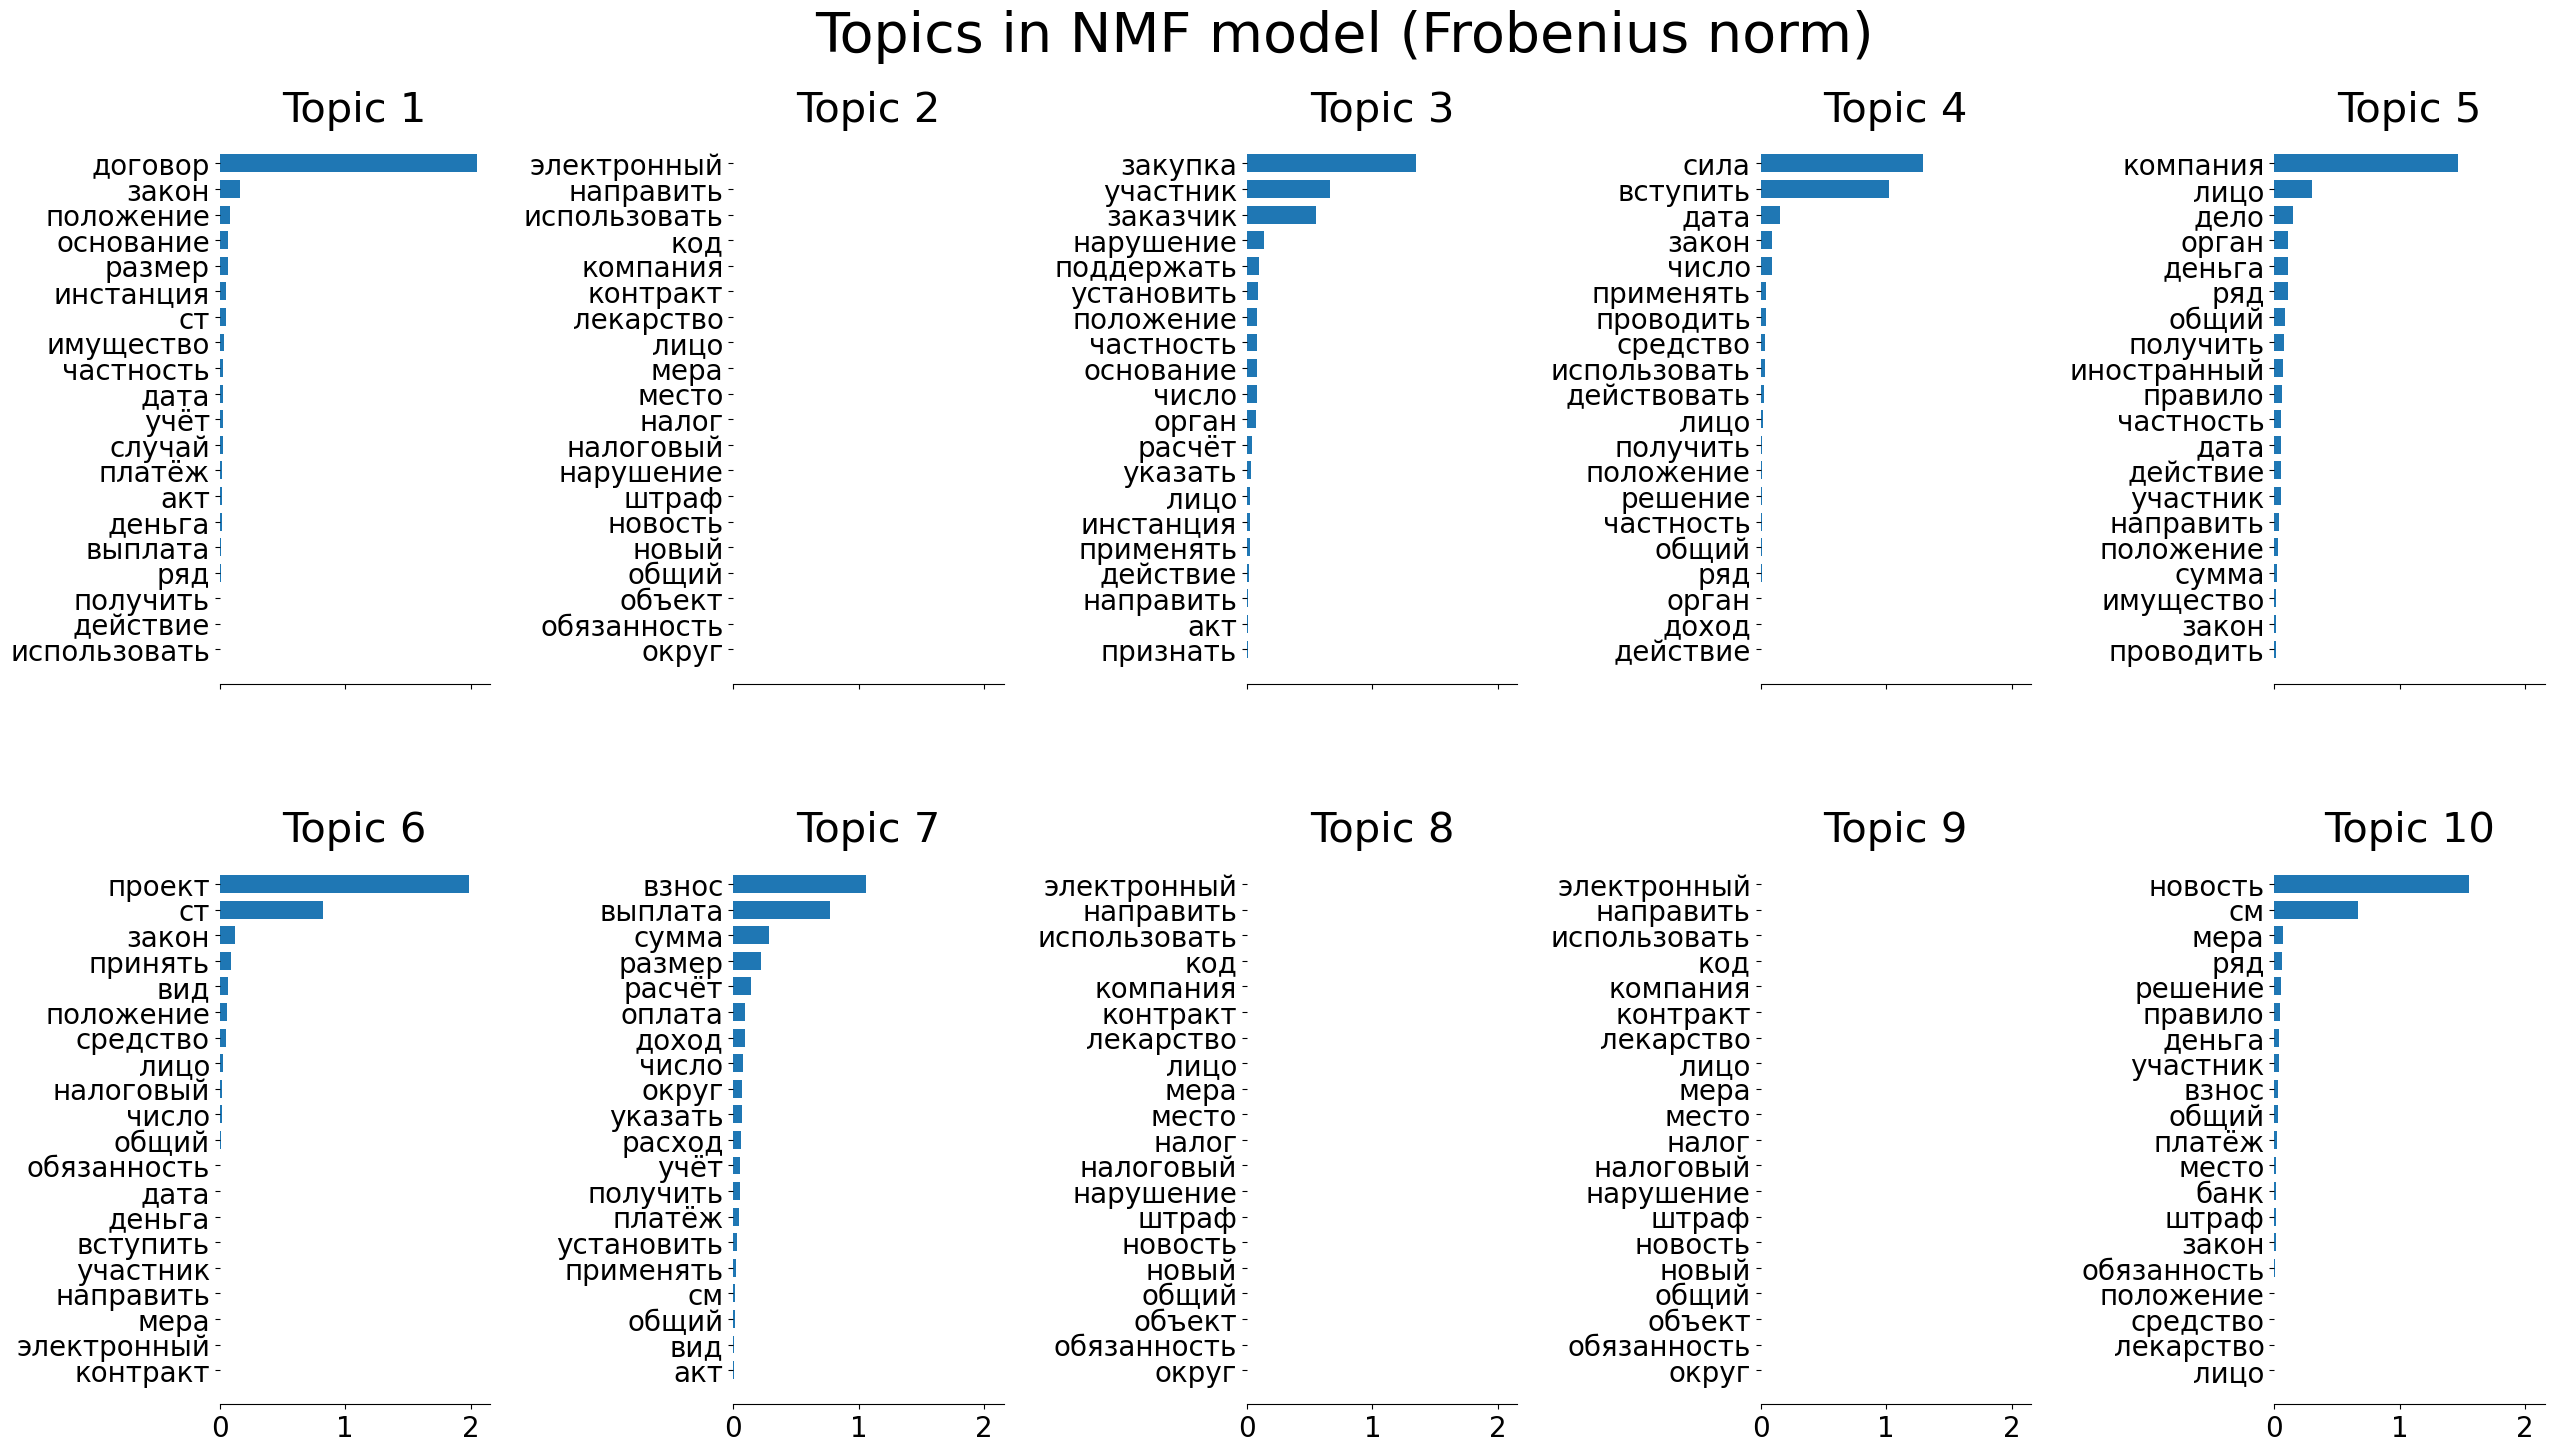

In [27]:
# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)





 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=1863 and n_features=100...
done in 0.853s.


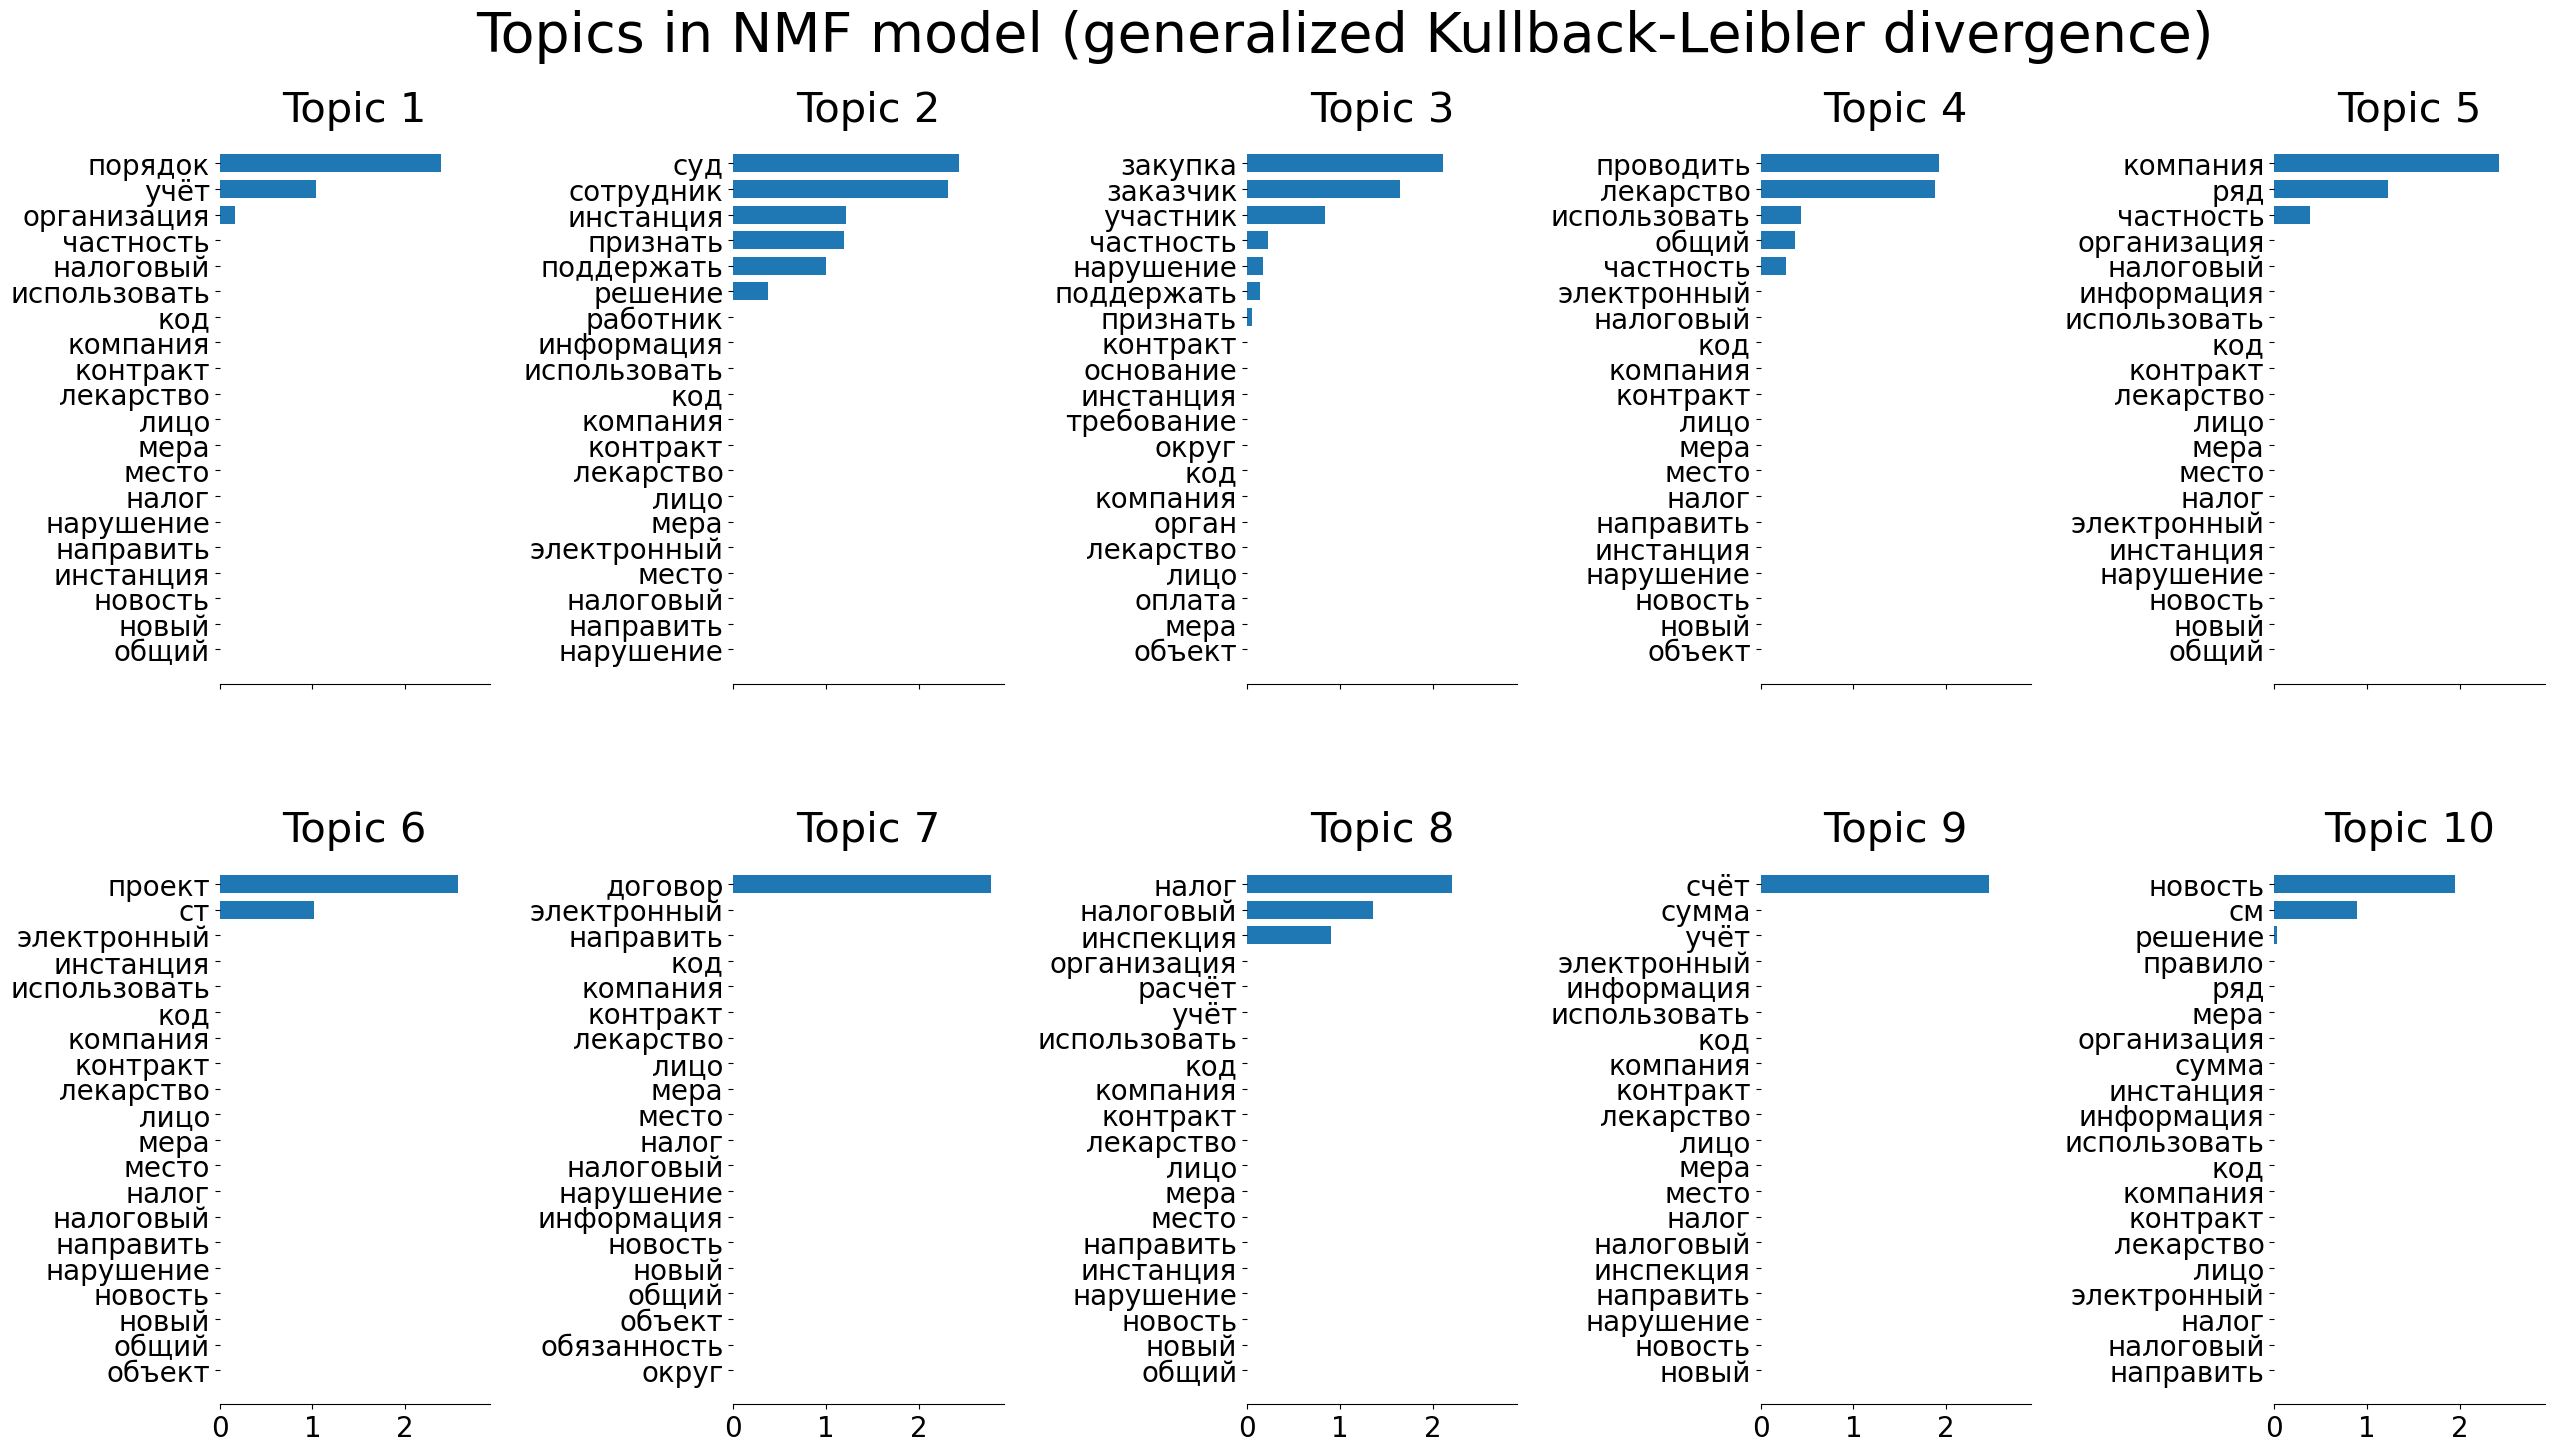

In [28]:
# Fit the NMF model
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)




 Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_samples=1863 and n_features=100, batch_size=128...
done in 0.193s.


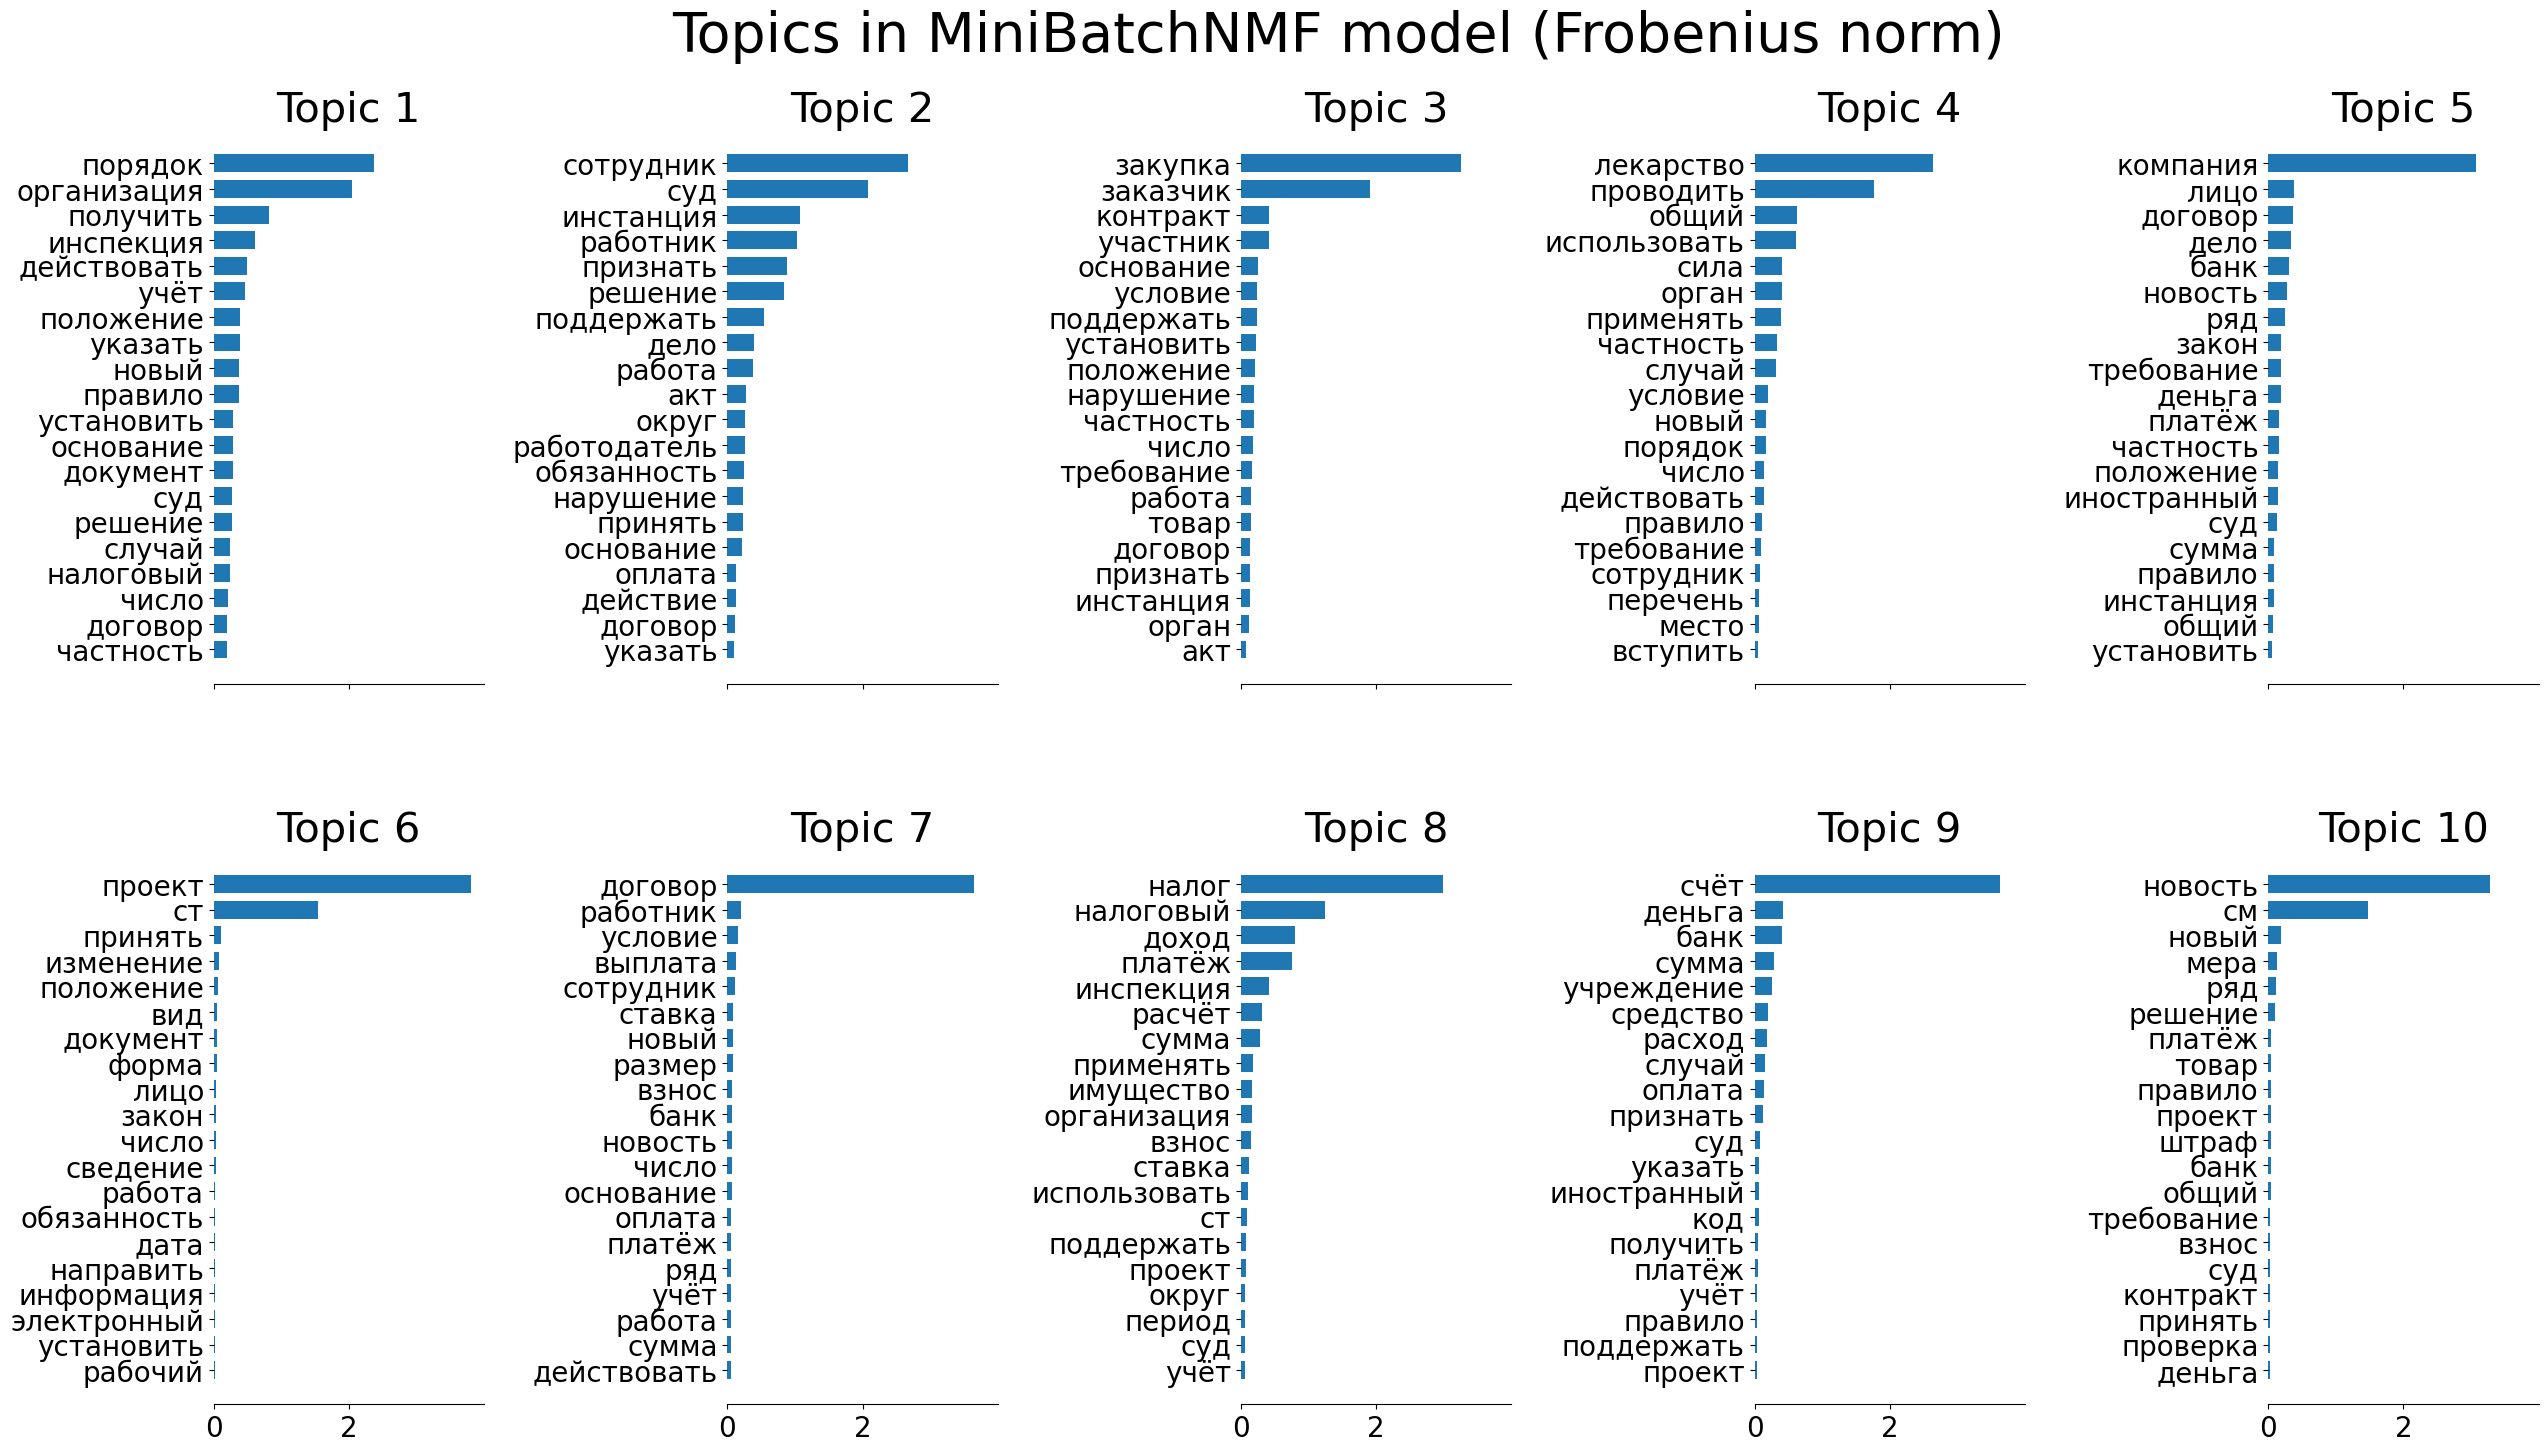

In [29]:
# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    "features, n_samples=%d and n_features=%d, batch_size=%d..."
    % (n_samples, n_features, batch_size),
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)





 Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=1863 and n_features=100, batch_size=128...
done in 0.984s.


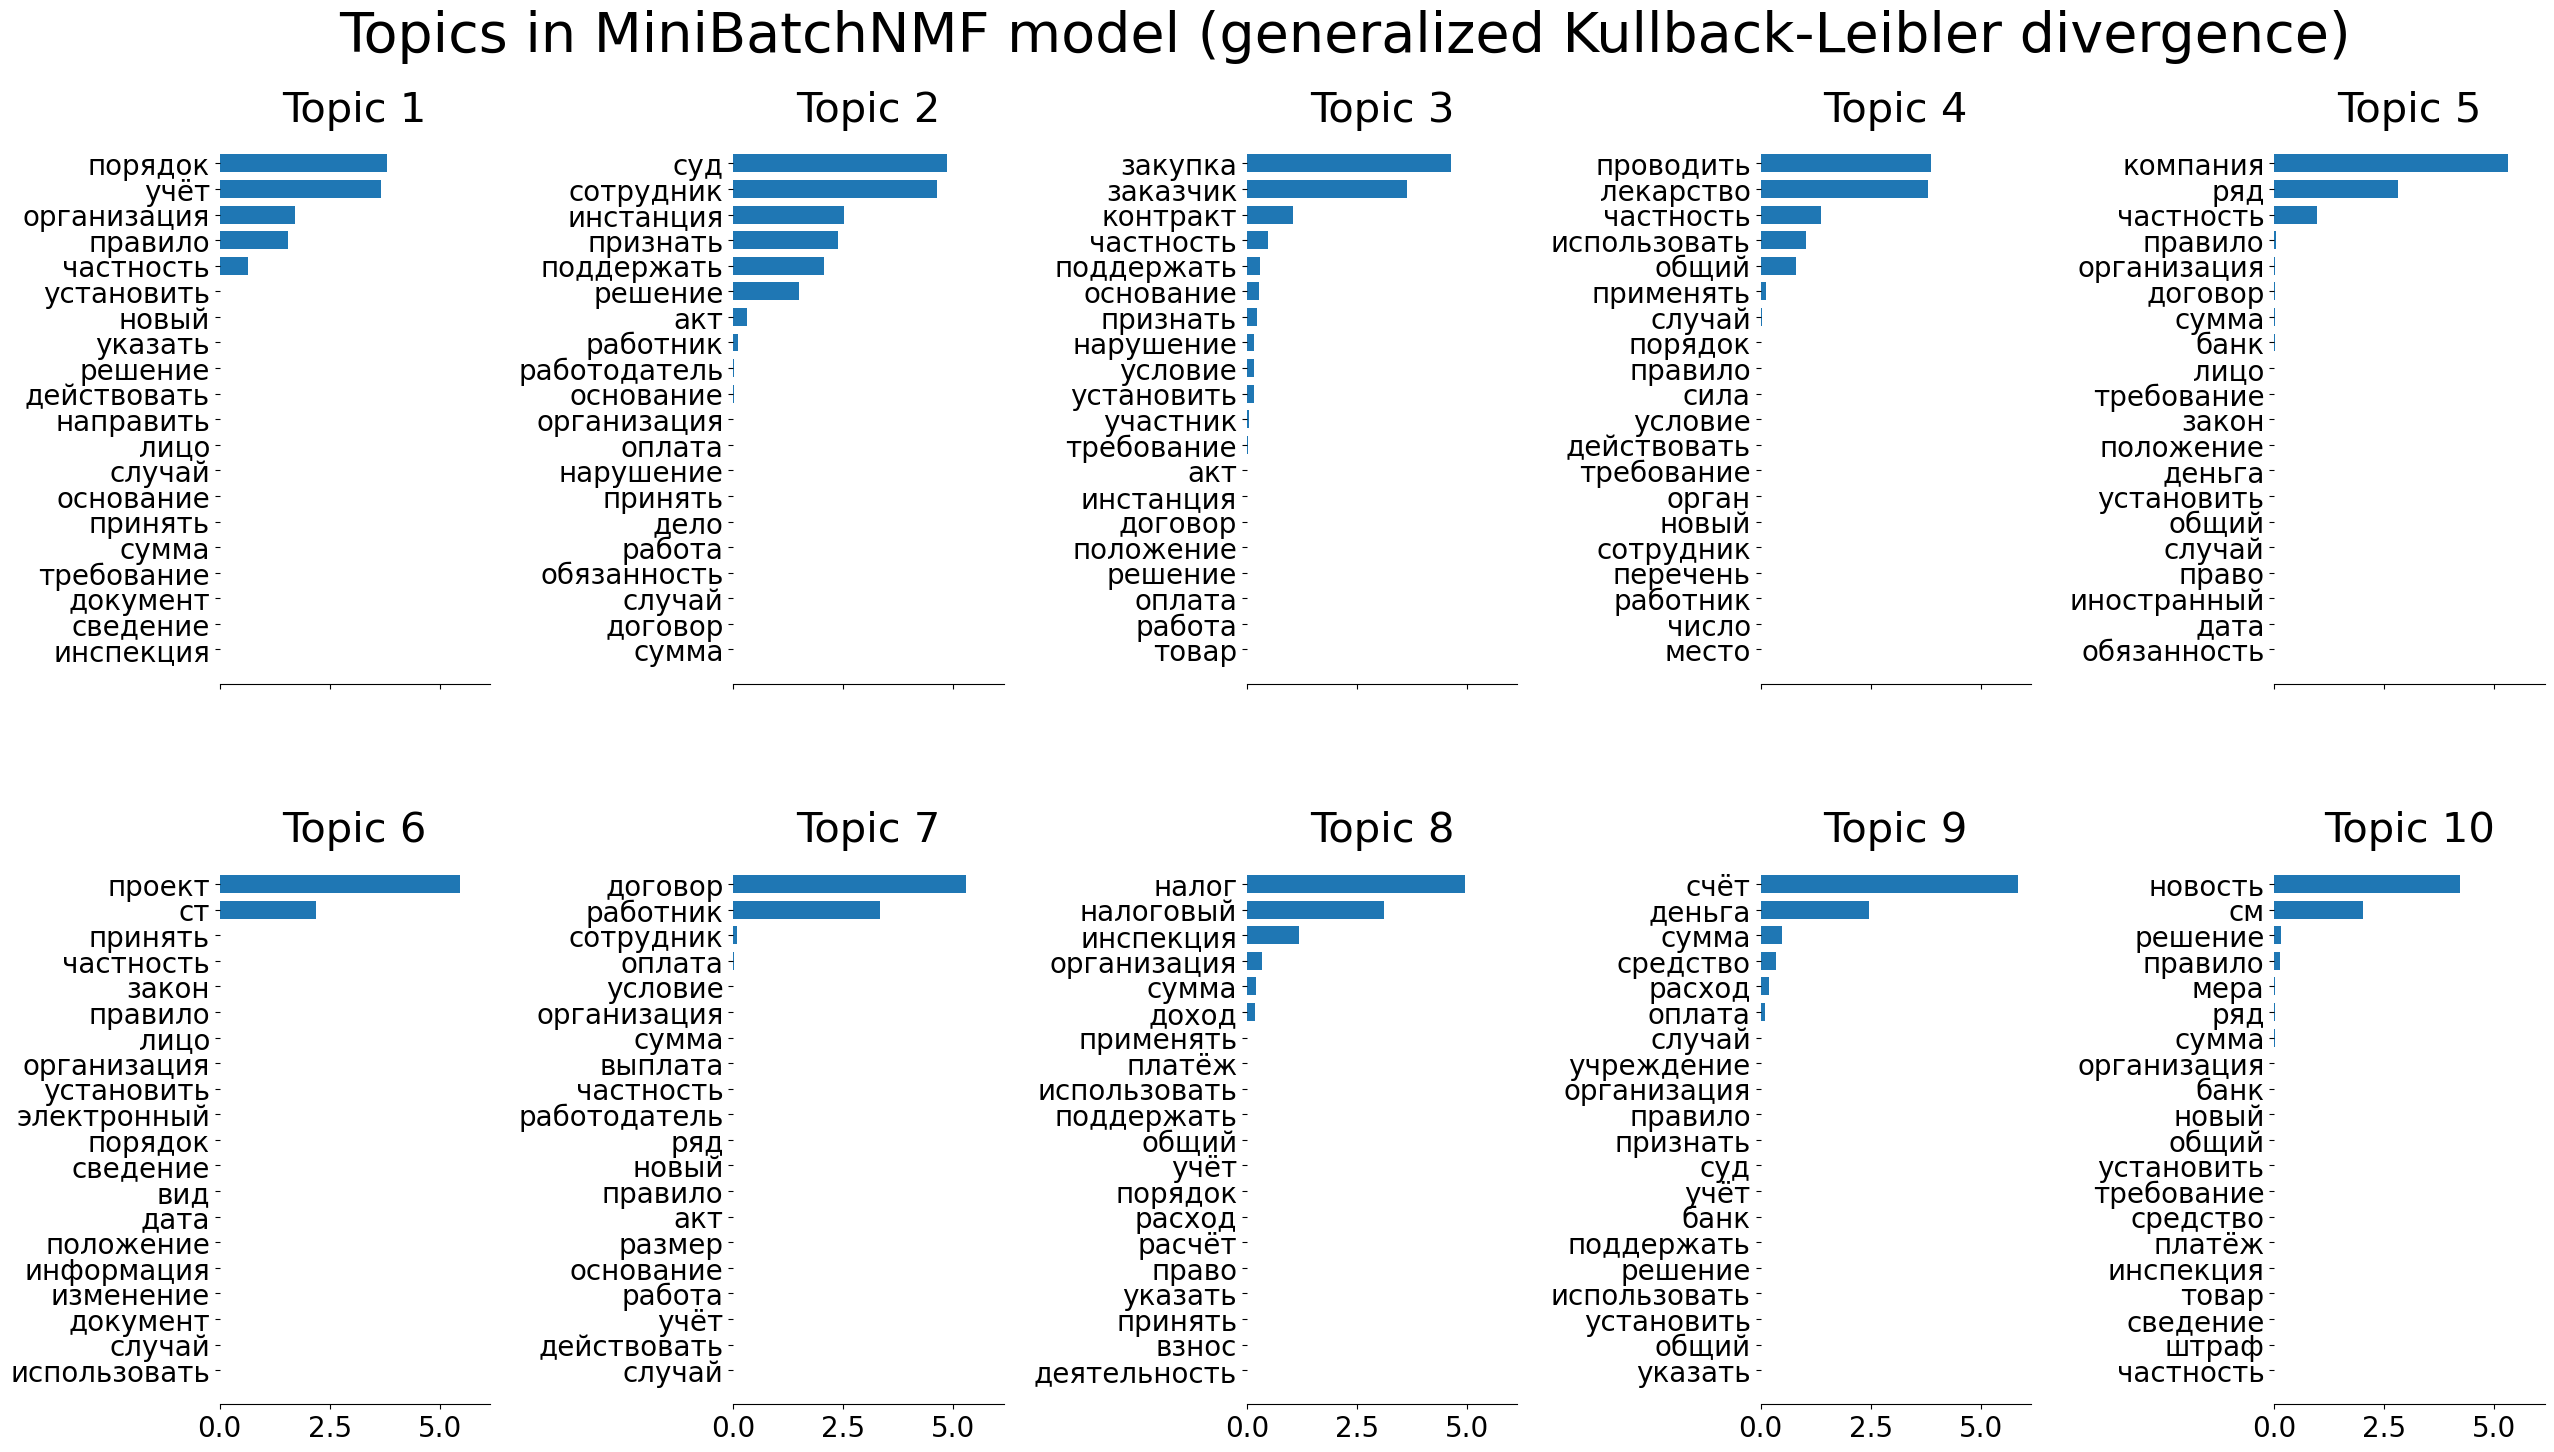

In [30]:
# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d, "
    "batch_size=%d..." % (n_samples, n_features, batch_size),
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)




 Fitting LDA models with tf features, n_samples=1863 and n_features=100...
done in 1.757s.


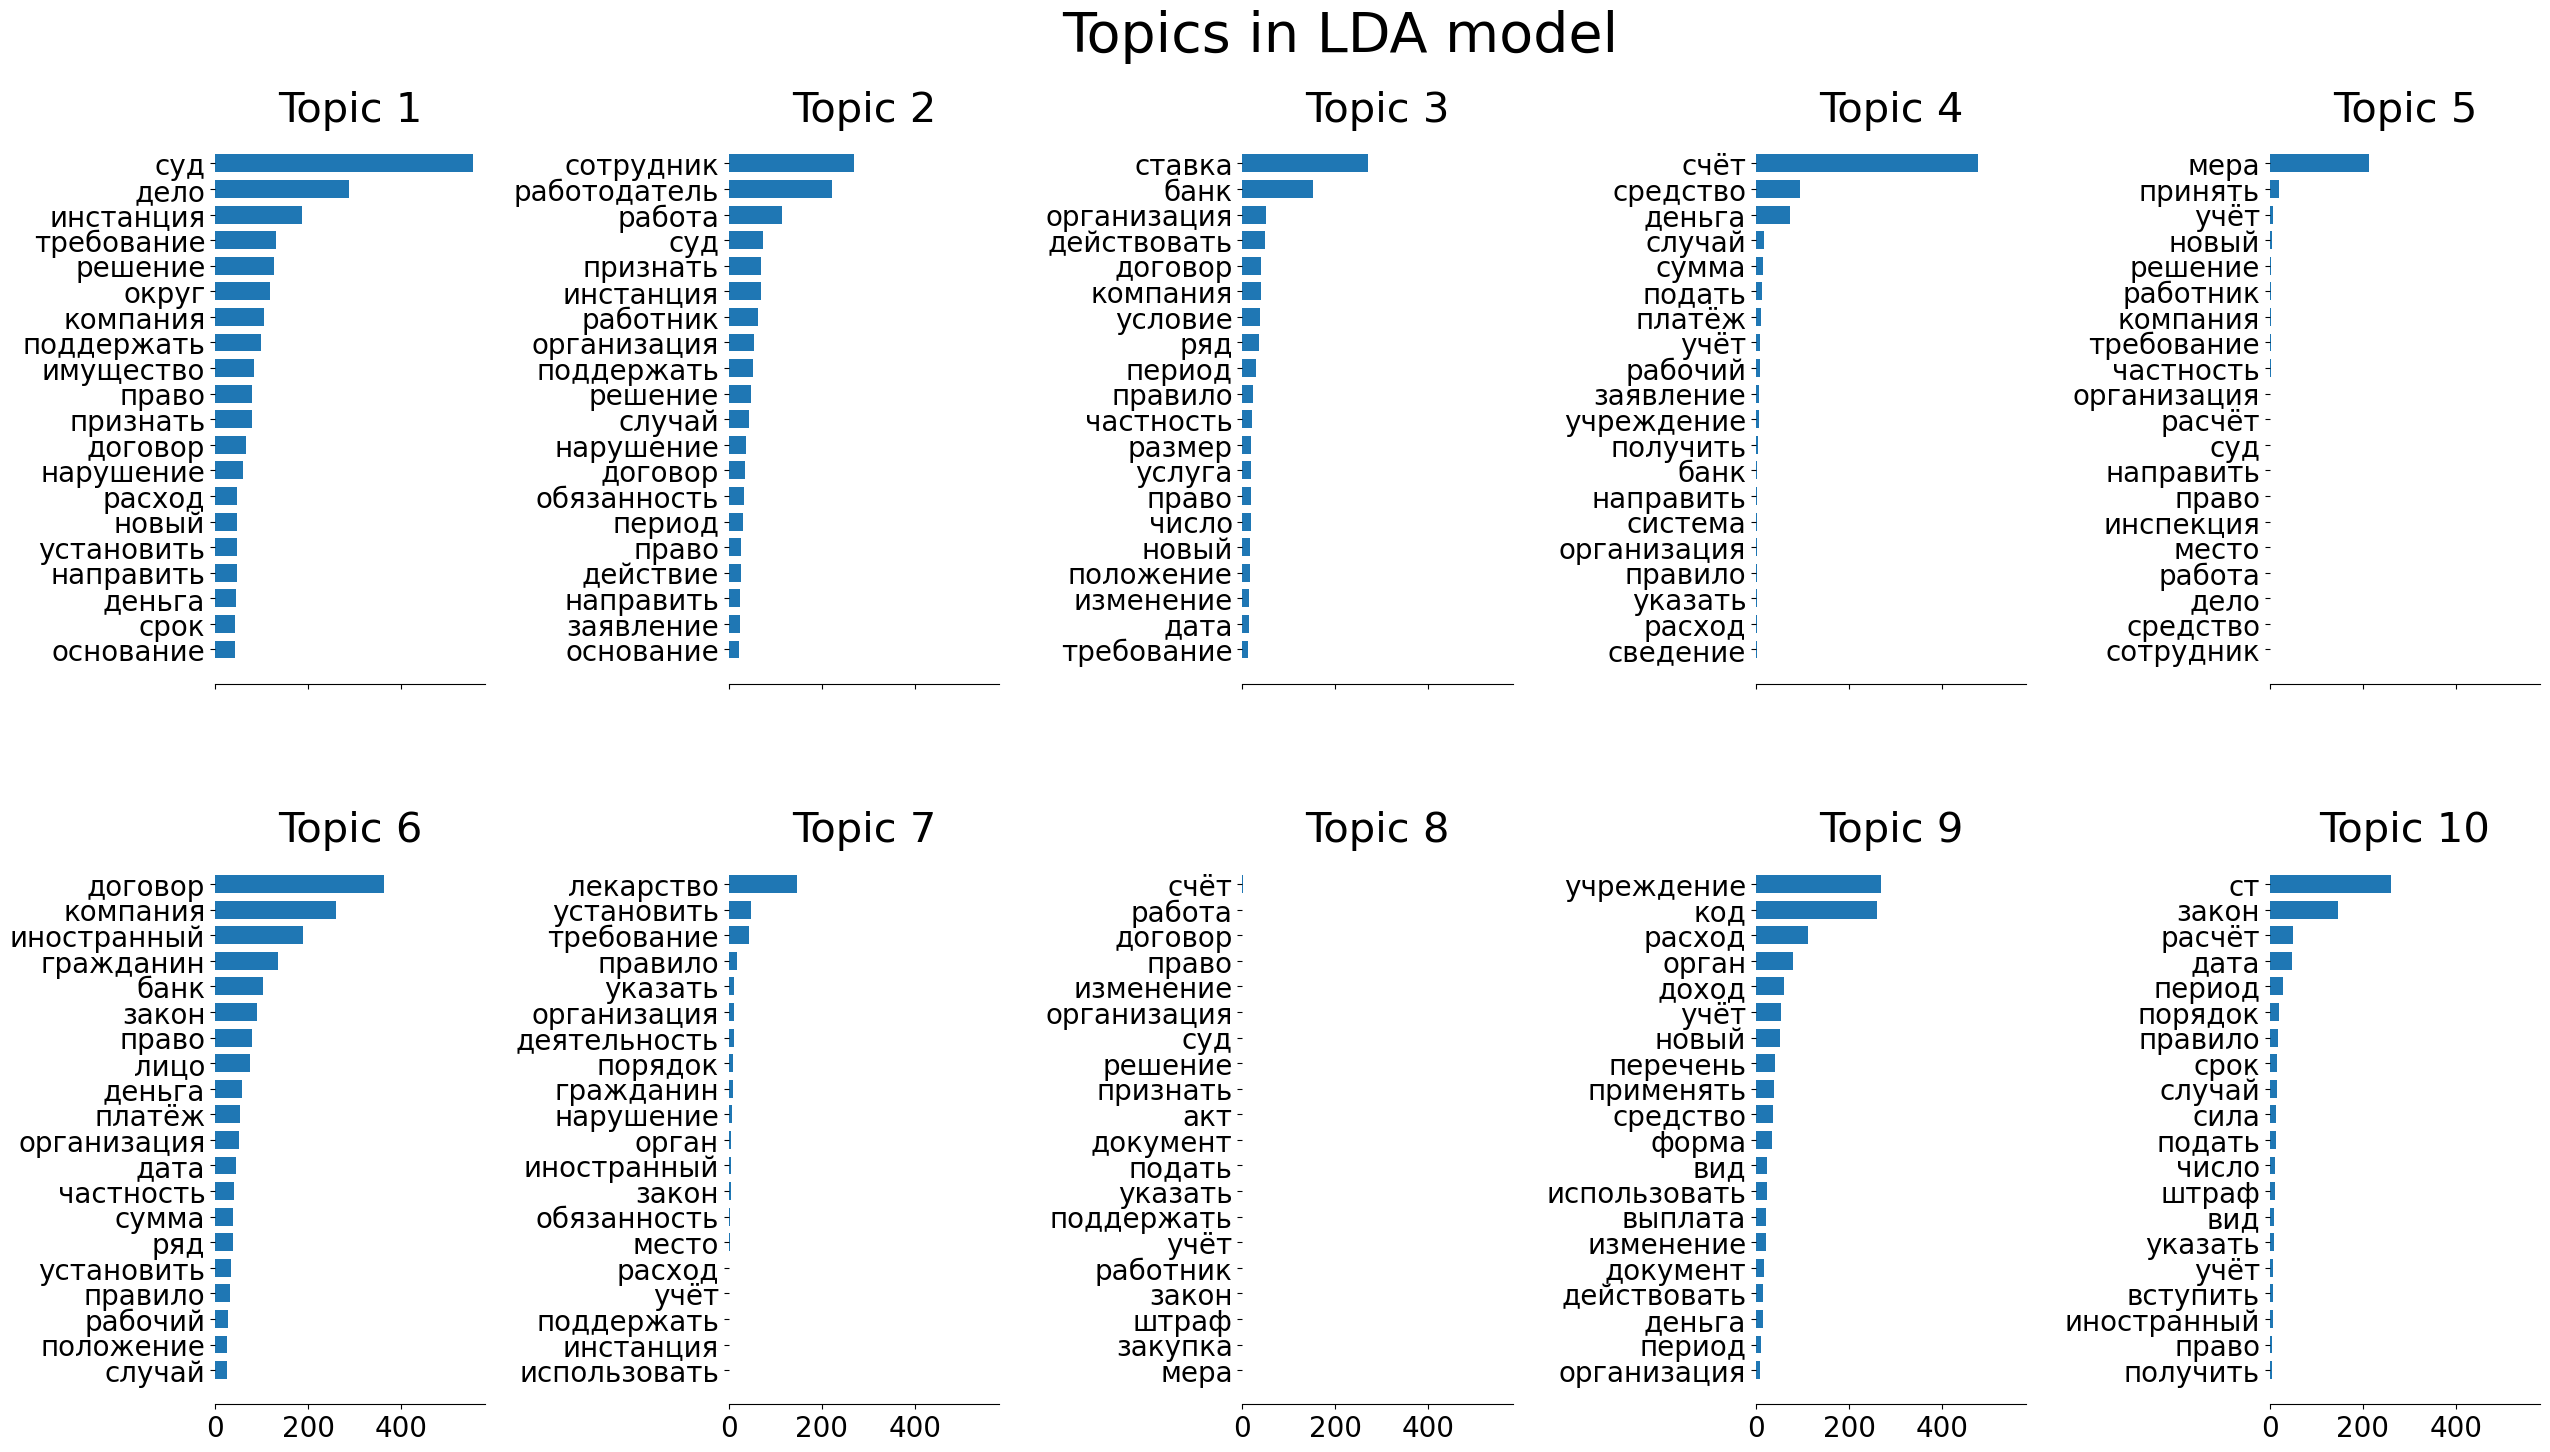

In [31]:
print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")



 Fitting LDA models with tf-idf features, n_samples=1863 and n_features=100...
done in 0.973s.


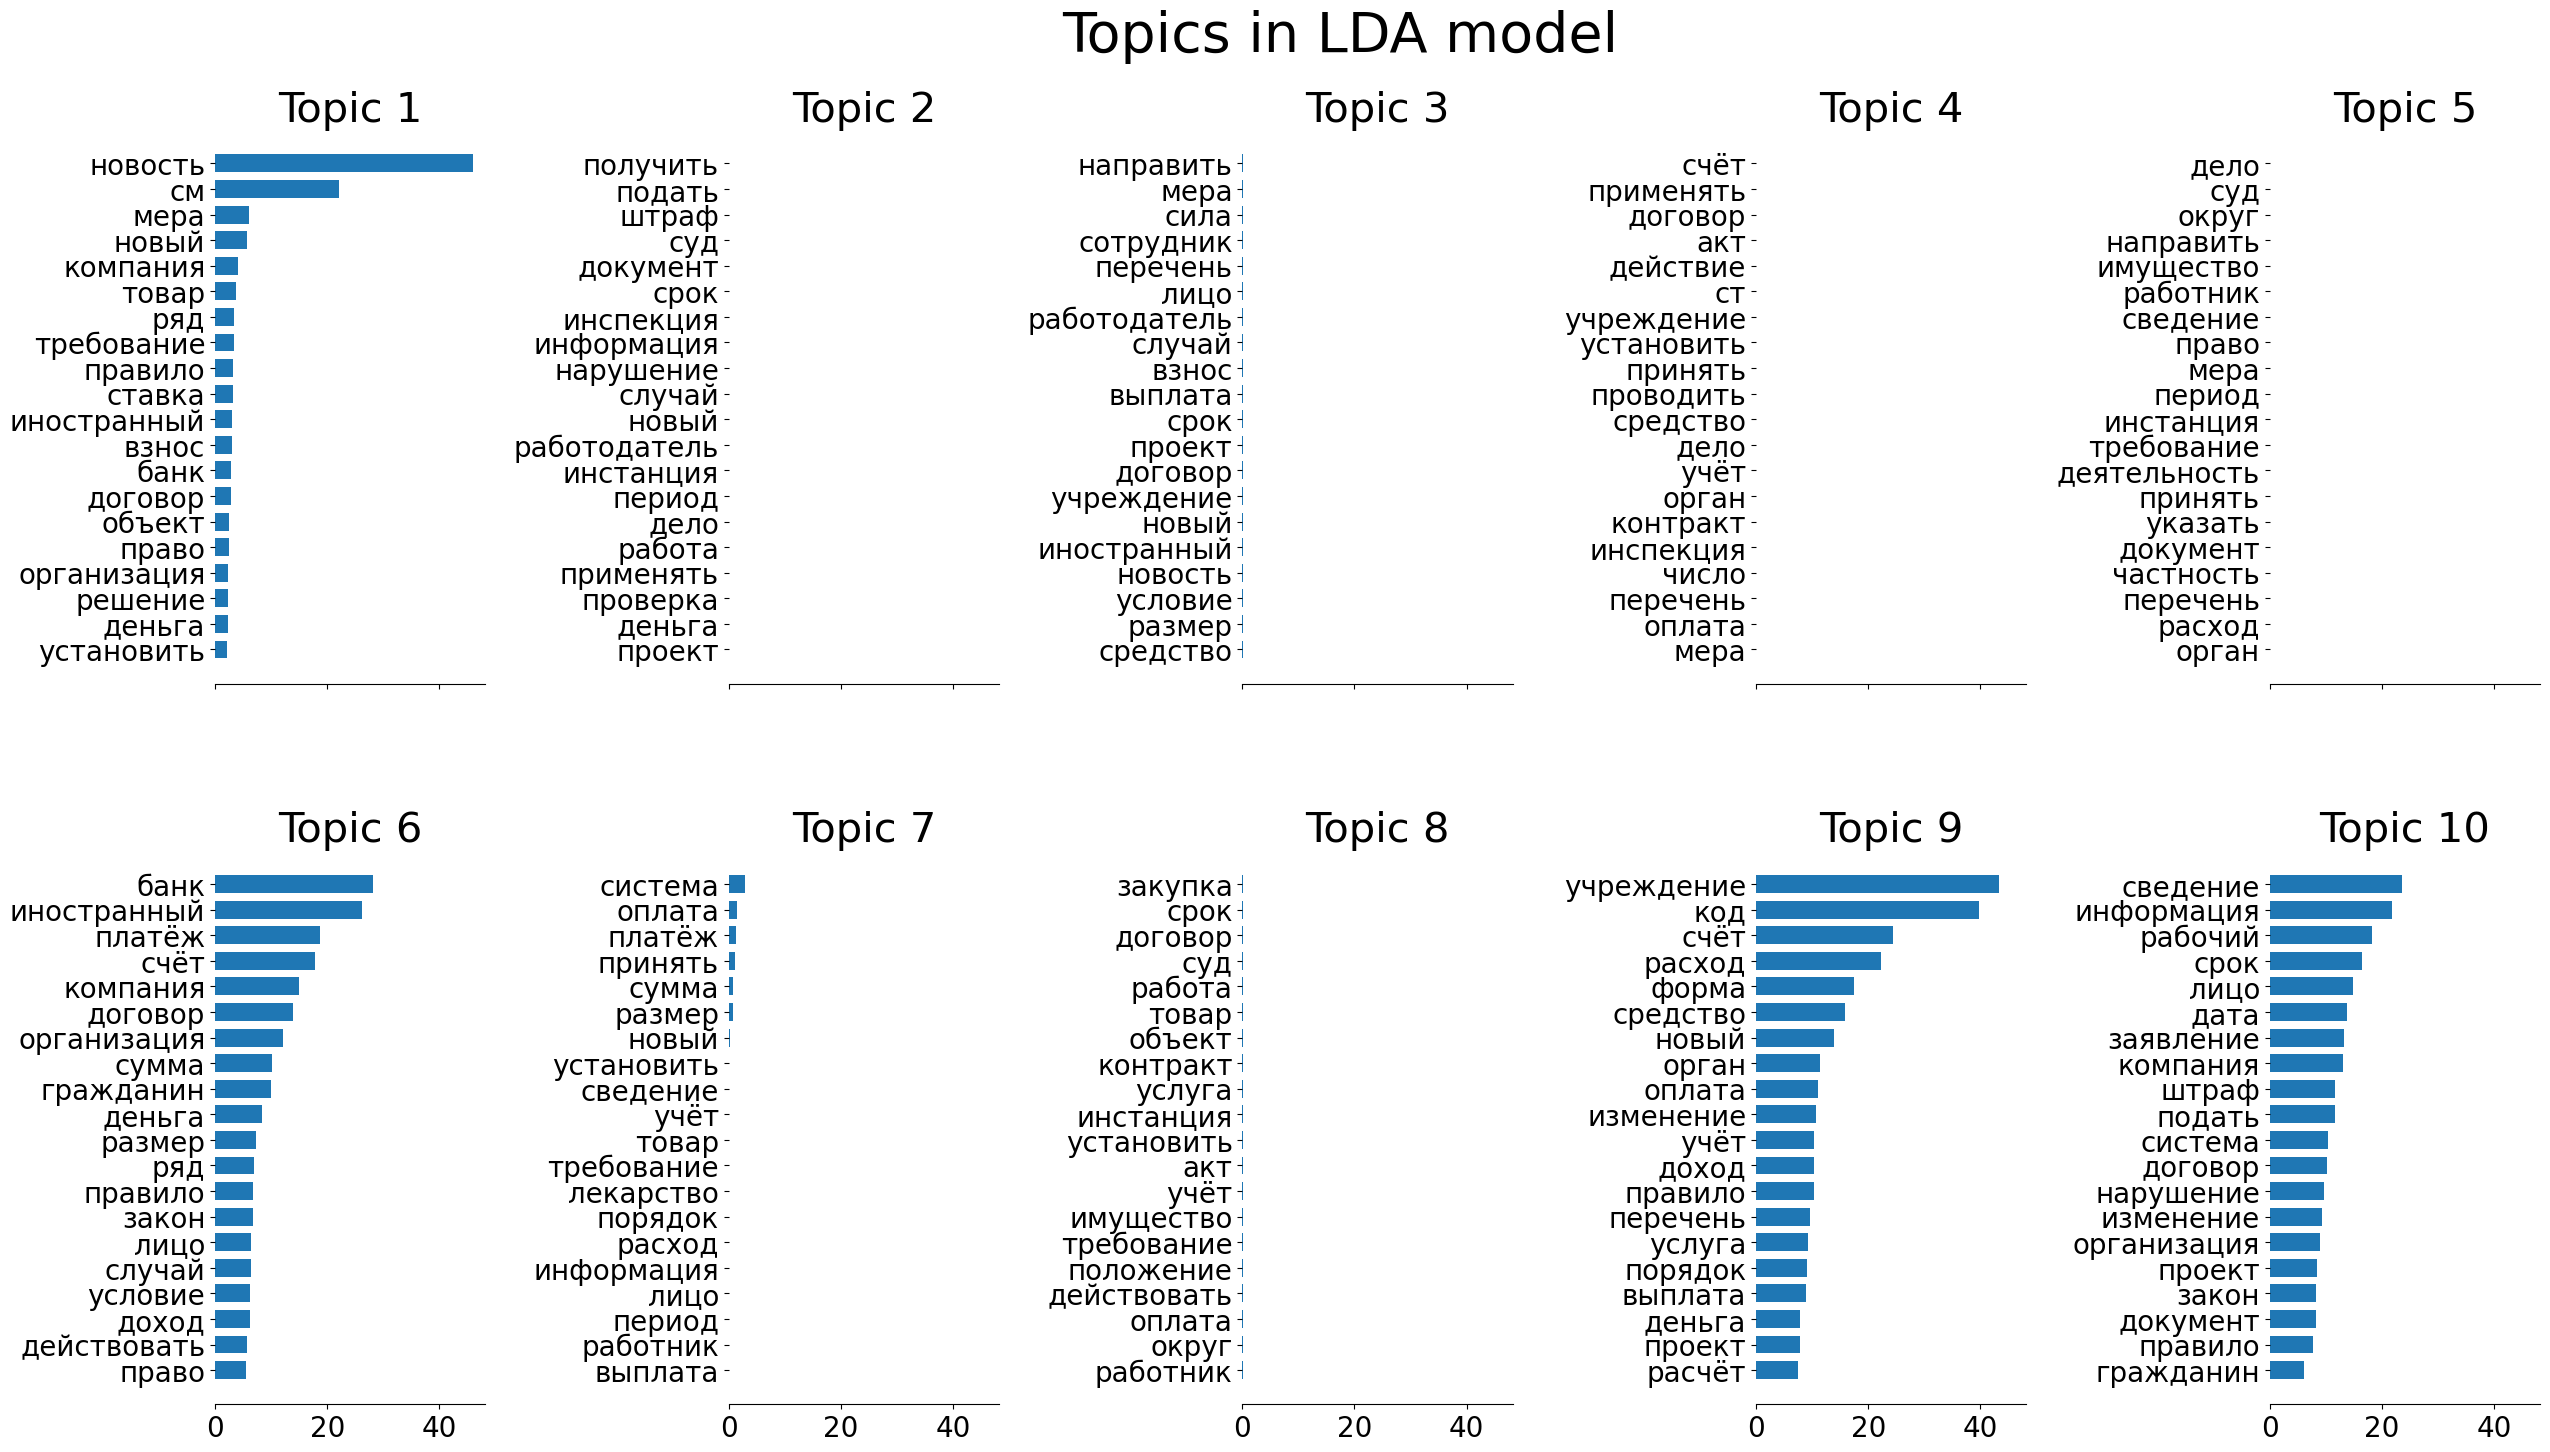

In [32]:
print(
    "\n" * 2,
    "Fitting LDA models with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

In [34]:
lda.components_.shape

(50, 100)

In [41]:
lda.components_

array([[0.0579953 , 2.9244829 , 2.97037461, ..., 0.82234729, 2.00239108,
        1.11111532],
       [0.04909709, 0.04612676, 0.05214525, ..., 0.04658102, 0.06692551,
        0.04931945],
       [0.04906488, 0.05066204, 0.06192113, ..., 0.04751538, 0.04343006,
        0.052919  ],
       ...,
       [0.08072532, 0.58741663, 7.38191798, ..., 0.93963449, 1.15362391,
        1.17410459],
       [0.04581145, 0.0516151 , 0.05162167, ..., 0.05190536, 0.04890871,
        0.04713265],
       [0.10109817, 0.05268999, 0.05791643, ..., 0.10078196, 0.05550202,
        0.05108269]])

In [36]:
lda.exp_dirichlet_component_.shape

(50, 100)

In [42]:
lda.exp_dirichlet_component_

array([[9.89471577e-11, 1.20886858e-02, 1.23144599e-02, ...,
        1.98388718e-03, 7.56916935e-03, 3.29307154e-03],
       [1.84778102e-10, 4.95511288e-11, 6.10590187e-10, ...,
        6.12596395e-11, 4.31310184e-08, 2.02618490e-10],
       [1.82777158e-10, 3.48365395e-10, 1.28284908e-08, ...,
        9.38080881e-11, 1.28744240e-11, 8.11219612e-10],
       ...,
       [7.91381252e-09, 6.09777286e-04, 2.05383173e-02, ...,
        1.50888712e-03, 2.10235262e-03, 2.16009895e-03],
       [4.32723141e-11, 5.08187620e-10, 5.09447212e-10, ...,
        5.66590786e-10, 1.73230836e-10, 7.99525811e-11],
       [5.69798680e-06, 5.99751596e-10, 3.35143805e-09, ...,
        5.52137189e-06, 1.57557136e-09, 3.29274502e-10]])

In [66]:
df_topics = pd.DataFrame(lda.components_.T,
                         columns=[f"Topic_{i}" for i in range(n_components)],
                         index=tf_vectorizer.get_feature_names_out())
df_topics

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,...,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44,Topic_45,Topic_46,Topic_47,Topic_48,Topic_49
акт,0.057995,0.049097,0.049065,0.054111,0.049726,0.717138,0.058095,0.062668,3.211292,1.401109,...,0.049748,0.133356,0.048660,0.049333,0.043725,0.066506,0.054409,0.080725,0.045811,0.101098
банк,2.924483,0.046127,0.050662,0.050377,0.048766,28.229471,0.045965,0.055729,0.205679,4.473185,...,0.065081,0.065804,0.047456,0.047471,0.049996,0.049336,0.048779,0.587417,0.051615,0.052690
взнос,2.970375,0.052145,0.061921,0.049376,0.048998,2.133126,0.050447,0.051537,2.420200,0.048188,...,0.070768,0.049927,0.045959,0.070717,0.049826,0.052955,0.050476,7.381918,0.051622,0.057916
вид,0.764188,0.045494,0.045951,0.049617,0.048629,4.420849,0.065022,0.054224,5.183222,5.103949,...,0.047873,0.064874,0.046489,0.048785,0.046467,0.052028,0.053040,4.660749,0.045793,0.052569
вступить,1.093649,0.046894,0.048208,0.050839,0.045495,3.342489,0.047598,0.049285,0.706397,4.477154,...,0.049740,0.051848,0.051714,0.053017,0.045804,0.048765,0.070365,2.645658,0.043864,0.104731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
форма,0.929823,0.048799,0.047515,0.050068,0.049525,2.152653,0.055850,0.052707,17.397492,4.344318,...,0.052686,0.052427,0.049760,0.047206,0.048385,0.053397,0.050044,3.992323,0.053299,0.072995
частность,1.306854,0.048103,0.050929,0.048053,0.054838,5.357956,0.056889,0.052451,2.861004,3.196141,...,0.046183,0.053986,0.053170,0.046740,0.049744,0.058089,0.048215,0.064680,0.052265,0.060043
число,0.822347,0.046581,0.047515,0.052322,0.048583,3.381522,0.058802,0.052799,3.416486,3.690169,...,0.050206,1.483554,0.053945,0.050734,0.053232,0.069540,0.050399,0.939634,0.051905,0.100782
штраф,2.002391,0.066926,0.043430,0.048078,0.048223,2.570264,0.048512,0.055588,1.541190,11.593415,...,0.052895,0.049806,0.050375,0.052341,0.063588,0.061889,0.066067,1.153624,0.048909,0.055502


In [73]:
df_topics.describe()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,...,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44,Topic_45,Topic_46,Topic_47,Topic_48,Topic_49
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.024452,0.051783,0.051664,0.049630,0.051305,4.095540,0.140853,0.054632,4.941054,4.473608,...,0.057339,0.211234,0.050793,0.054857,0.050534,0.061848,0.052858,3.358707,0.051121,0.063160
std,5.021443,0.005426,0.005576,0.002780,0.004437,4.855160,0.358369,0.007516,6.969086,4.705800,...,0.012693,0.901833,0.004353,0.009652,0.004429,0.022579,0.006484,5.129768,0.004177,0.018609
min,0.053372,0.044327,0.042690,0.042234,0.043757,0.060641,0.044510,0.043795,0.051413,0.048188,...,0.044456,0.041505,0.044156,0.043557,0.043725,0.044172,0.043669,0.046407,0.043864,0.042896
25%,0.568921,0.048507,0.048327,0.047866,0.048504,1.404375,0.050829,0.050811,1.093554,1.224973,...,0.049722,0.049315,0.048440,0.049634,0.047685,0.050606,0.048376,0.617725,0.048563,0.051440
50%,1.158384,0.050570,0.050704,0.049512,0.050456,2.920051,0.056664,0.052588,2.775646,3.366476,...,0.053542,0.053029,0.050534,0.052012,0.049695,0.056521,0.051369,1.576911,0.050343,0.056718
75%,1.990383,0.053097,0.053049,0.051499,0.053295,4.717361,0.070015,0.055760,5.901119,5.086748,...,0.058833,0.065395,0.052364,0.058529,0.052351,0.066326,0.054678,3.723712,0.053070,0.067272
max,45.947440,0.076685,0.071342,0.058119,0.077061,28.229471,2.866684,0.085543,43.356016,23.659333,...,0.130366,8.694419,0.073638,0.108789,0.069847,0.214238,0.075259,36.694349,0.065648,0.171798
